In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

In [2]:
MODEL = 'ssd_inception_v2_coco'
DATA_DIR = './data/'
CONFIG_FILE = MODEL + '.config'   # ./data/ssd_inception_v2_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_inception_v2_coco/model.ckpt
IMAGE_PATH = './data/huskies.jpg'

### Download the pretrained model

Download the model configuration file and checkpoint containing pretrained weights by using the following command.  

For improved performance, increase the non-max suppression score threshold in the downloaded config file from 1e-8 to something greater, like 0.1.

In [3]:
config_path, checkpoint_path = download_detection_model(MODEL, 'data')

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path
)

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Restoring parameters from data/ssd_inception_v2_coco/model.ckpt
INFO:tensorflow:Froze 410 variables.
Converted 410 variables to const ops.


### Optimize the model with TensorRT

In [7]:
print(output_names)

['scores', 'classes', 'boxes']


In [8]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

In [9]:
with open('./data/ssd_inception_v2_coco_trt.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

### Create session and load graph

In [10]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('classes:0')

### Load and Preprocess Image

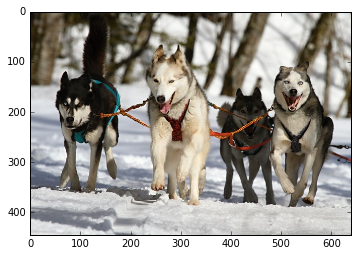

In [11]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

### Run network on Image

In [12]:
scores, boxes, classes = tf_sess.run([tf_scores, tf_boxes, tf_classes], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]

### Display Results

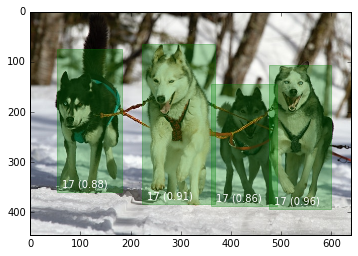

In [13]:
score_thresh = 0.85

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(len(scores)):
    if scores[i] > score_thresh:
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
        
        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)
        
        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

### Close session to release resources

In [14]:
tf_sess.close()